In [1]:
import torch

from tqdm.auto import tqdm

from point_e.diffusion.configs import diffusion_from_config
from point_e.models.configs import model_from_config
from point_e.config import MODEL_CONFIGS,DIFFUSION_CONFIGS

from point_e.utils.download import load_checkpoint
from point_e.diffusion.sampler import PointCloudSampler
from point_e.utils.plotting import plot_point_cloud

/home/aioz-nghiale/anaconda3/envs/point_e_revised/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('images', ''), # Do not condition the upsampler at all
    # use_karras = (False,False)
)

In [4]:
from PIL import Image
# Set a prompt to condition on.
img = Image.open('asset/helmet.webp')

# Produce a sample from the model.
samples_set = []
count = 0
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    if count%13 == 0: samples_set.append(x)
    count+=1

0it [00:00, ?it/s]

66it [00:32,  3.21it/s]

done with one


130it [00:52,  2.48it/s]

done with one


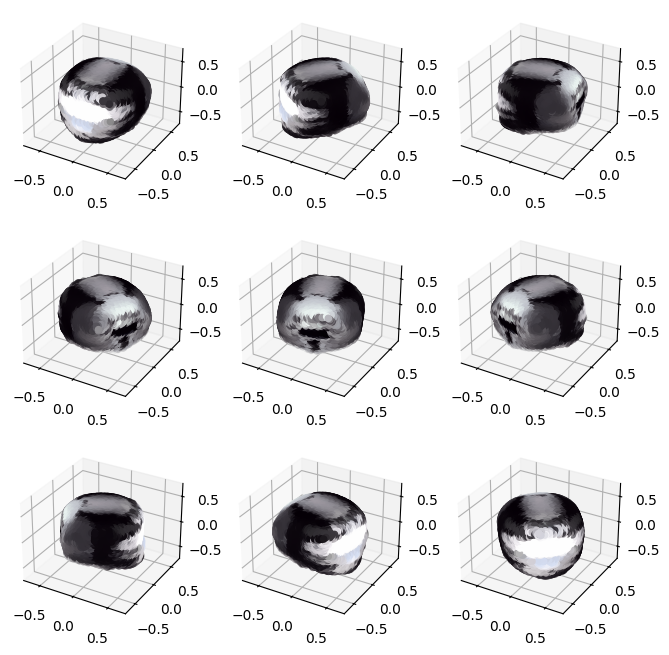

In [5]:
pc = sampler.output_to_point_clouds(samples_set[9])[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))